In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))


True
0
NVIDIA GeForce RTX 4080


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# output : "cuda"

cuda


In [3]:
!pip install koreanize-matplotlib

In [4]:
import koreanize_matplotlib

In [5]:
'''
# 한글 폰트 설치 런타임 재시작 이후 셀 실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

'\n# 한글 폰트 설치 런타임 재시작 이후 셀 실행\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

In [6]:
# # 현재 작업 디렉토리
# !pwd

In [7]:
# # 구글 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# 원하는 위치로 경로 바꾸기
# 본인이 만든 폴더 위치를 사용
%cd /content/drive/MyDrive/mulcama_bigdata

[WinError 3] 지정된 경로를 찾을 수 없습니다: '/content/drive/MyDrive/mulcama_bigdata'
c:\Users\USER\Desktop\mulcam\mulcam_code\주간프로젝트\임태수


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


#### 패키지 설치 및 라이브러리 로드

In [9]:

!pip install pandas nltk
!pip install konlpy
!pip install wordcloud


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
import re
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings

from matplotlib import font_manager, rc
from scipy.stats import f_oneway
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import tee
from scipy.stats import chi2_contingency

from wordcloud import WordCloud
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [11]:
# plt.rc('font', family='NanumBarunGothic')

In [12]:
# CSV 파일 읽기
df = pd.read_csv("./알리_베스트셀러_리뷰.csv", encoding='UTF-8') ; df.head(5)

,상품명,가격,평점,댓글,별점,링크
0,"SCVCN 사이클링 안경 자전거 선글라스, 남성 UV400 안경, 스포츠 MTB 야...","1,391",4.7,NaN,NaN,https://ko.aliexpress.com/item/100500592463696...
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...","1,391",4.8,배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500592457862...
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...","1,125",4.7,감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...,5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...,https://ko.aliexpress.com/item/100500522141320...
3,"접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...","25,785",4.7,뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...,5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...,https://ko.aliexpress.com/item/100500593200533...
4,"BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, ...","16,411",4.8,생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...,5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500626084886...


# 데이터셋 살펴보기

In [13]:
# dimension
df.shape

(291, 6)

In [14]:
# 결측치
df.isnull().sum()

상품명     0
가격      0
평점      0
댓글     21
별점      5
링크      0
dtype: int64

In [15]:
cond = df['댓글'].isnull()
df_clean = df.loc[~cond]


# 25개 제품의 null값이 존재하여 날림
# 25개의 제품 각각에 댓글을을 합산하여도 충분한 수치의 데이터 보유
# 25개의 제품의 null값은 댓글이 없고 별점도 없는 인덱스의 row이기 때문에 날리기로 함

In [16]:
#결측지 제거 확인
df_clean.isnull().sum()

상품명    0
가격     0
평점     0
댓글     0
별점     0
링크     0
dtype: int64

In [17]:
df_clean['댓글'].head()

1    배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...
2    감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...
3    뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...
4    생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...
5    잘받았습니다\n좋아요 가격대비 만족합니다\n진짜 빨리받앗어요. 일주일?? 턱걸이하는...
Name: 댓글, dtype: object

In [18]:
# 별점을 정수형 리스트로 변환
def split_stars(stars):
    return list(map(int, stars.split('\n')))

# 각 행에 대해 별점 리스트로 변환
df_clean['star_list'] = df_clean['별점'].apply(split_stars)

# 별점 분포를 계산하기 위한 별점 리스트 플래트닝
all_stars = [star for stars in df_clean['star_list'] for star in stars]

# 별점별 빈도 계산
star_counts = pd.Series(all_stars).value_counts().sort_index()

# 별점별 빈도 출력
print(star_counts)

# 부정은 1점 (373) + 2점 (219) + 3점 (468)
# 긍정은 4점 (1506) + 5점 (9385)

1     373
2     219
3     468
4    1506
5    9385
Name: count, dtype: int64


In [19]:
def classify_sentiment(stars):
    # 별점을 정수형 리스트로 변환
    stars_list = list(map(int, stars.split('\n')))

    # 별점이 1, 2, 3 중 하나라도 있으면 부정, 모두 4 또는 5이면 긍정
    if any(star in [1, 2, 3] for star in stars_list):
        return '부정'
    elif all(star in [4, 5] for star in stars_list):
        return '긍정'
    else:
        return '알 수 없음'

In [20]:
# 별점을 정수형 리스트로 변환
def split_stars(stars):
    return list(map(int, stars.split('\n')))


# 각 행에 대해 별점 리스트로 변환
df_clean['star_list'] = df_clean['별점'].apply(split_stars)

# 별점 리스트를 긍정/부정 리스트로 변환
def classify_star_list(star_list):
    return ['긍정' if star in [4, 5] else '부정' for star in star_list]

# 별점 리스트에 대한 긍정/부정 리스트 추가
df_clean['review_assessment'] = df_clean['star_list'].apply(classify_star_list)

# 결과 확인
print(df_clean[['star_list', 'review_assessment']].head(10))

                                            star_list  \
1   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
2   [5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...   
3   [5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...   
4   [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, ...   
5   [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, ...   
6   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 4, 5, ...   
7   [5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 2, 2, 5, 4, ...   
8   [5, 5, 4, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, ...   
9   [5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...   
10  [5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, ...   

                                    review_assessment  
1   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
2   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...  
3   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
4   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
5   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
6   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정,

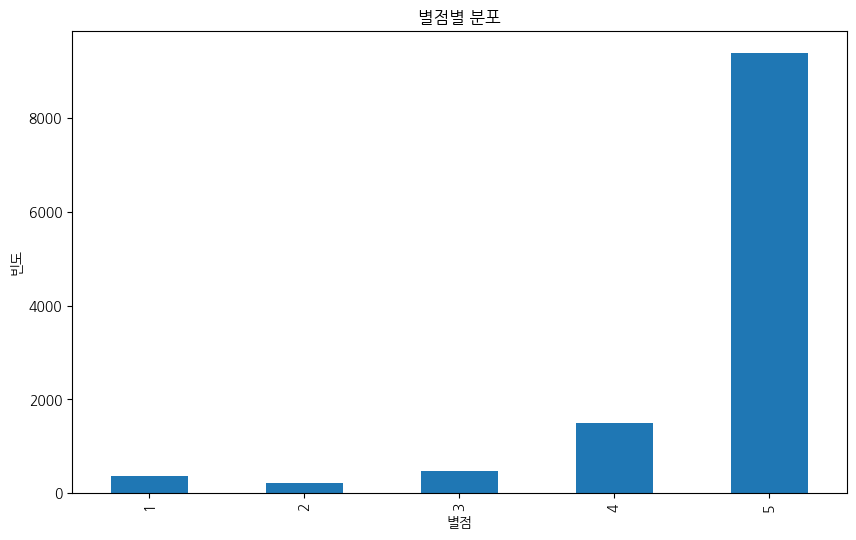

In [21]:
# 별점 분포 시각화
plt.figure(figsize=(10, 6))
star_counts.plot(kind='bar')
plt.xlabel('별점')
plt.ylabel('빈도')
plt.title('별점별 분포')
plt.show()

# 리뷰 시각화의 경우 대부분 긴꼬리분포로 (쏠림현상) 나타남. 정규화하지 않아도 됨.

In [22]:
# 각 상품별 긍정 및 부정 빈도수 계산
df_clean['긍정 빈도수'] = df_clean['review_assessment'].apply(lambda x: x.count('긍정'))
df_clean['부정 빈도수'] = df_clean['review_assessment'].apply(lambda x: x.count('부정'))


# 전체 긍정 및 부정 빈도수 계산
total_positive = df_clean['긍정 빈도수'].sum()
total_negative = df_clean['부정 빈도수'].sum()

print(f"전체 긍정 댓글 수: {total_positive}")
print(f"전체 부정 댓글 수: {total_negative}")


전체 긍정 댓글 수: 10891
전체 부정 댓글 수: 1060


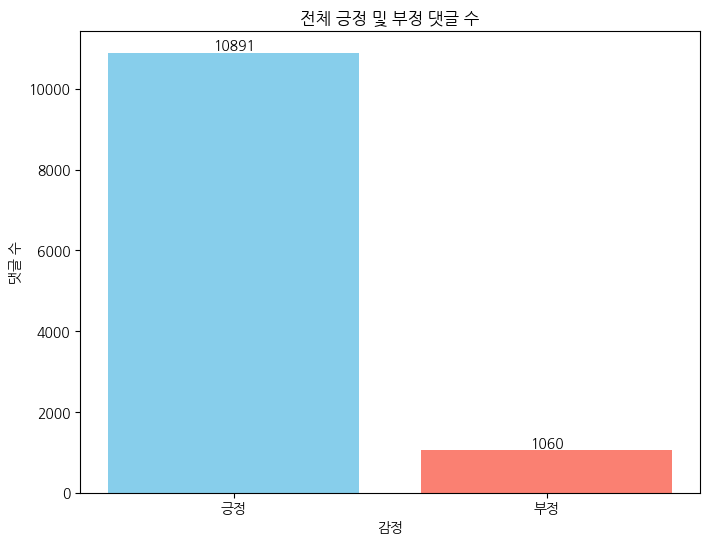

In [23]:
# 히스토그램 그리기
plt.figure(figsize=(8, 6))
bars = plt.bar(['긍정', '부정'], [total_positive, total_negative], color=['skyblue', 'salmon'])
plt.title('전체 긍정 및 부정 댓글 수')
plt.xlabel('감정')
plt.ylabel('댓글 수')

# 빈도수 텍스트 추가
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), ha='center', va='bottom')

plt.show()

In [24]:
df_clean.head(3)

,상품명,가격,평점,댓글,별점,링크,star_list,review_assessment,긍정 빈도수,부정 빈도수
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...","1,391",4.8,배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500592457862...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",39,4
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...","1,125",4.7,감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...,5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...,https://ko.aliexpress.com/item/100500522141320...,"[5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...",42,1
3,"접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...","25,785",4.7,뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...,5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...,https://ko.aliexpress.com/item/100500593200533...,"[5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",43,0


In [25]:
df_clean['댓글'] = df_clean['댓글'].str.split('\n')

In [26]:
# 확장된 데이터프레임 생성
expanded_rows = []
for idx, row in df_clean.iterrows():
    stars = row['star_list']
    comments = row['댓글']
    reviews = row['review_assessment']
    for star, comment, review in zip(stars, comments, reviews):
        expanded_rows.append({
            '상품명': row['상품명'],
            '댓글': comment,
            '가격': row['가격'],
            '별점': star,
            'review_list': review
        })

df_expanded = pd.DataFrame(expanded_rows)
df_expanded

,상품명,댓글,가격,별점,review_list
0,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,"1,391",5,긍정
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ,"1,391",5,긍정
2,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩에 ...,"1,391",5,긍정
3,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼...,"1,391",5,긍정
4,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.,"1,391",5,긍정
...,...,...,...,...,...
7445,"OTG USB 3.0 to C타입 어댑터, USB 암 to C타입 수 고속 충전 어...",좋아요.,"1,455",5,긍정
7446,"OTG USB 3.0 to C타입 어댑터, USB 암 to C타입 수 고속 충전 어...",꼽았는데 반응이 전혀읍네…뽑기실패…꼽았는데 반응이 전혀읍네…뽑기실패…꼽았는데 반응이...,"1,455",5,긍정
7447,"OTG USB 3.0 to C타입 어댑터, USB 암 to C타입 수 고속 충전 어...",감사합니다 잘 쓰겠습니다,"1,455",5,긍정
7448,"OTG USB 3.0 to C타입 어댑터, USB 암 to C타입 수 고속 충전 어...",좋아요 잘 쓰겠습니다.,"1,455",5,긍정


리뷰 평점 4 ~ 5점 리뷰는 대부분 긍정적
1 ~ 3점 리뷰에서는 부정

4점, 5점인 리뷰는 "긍정적인 리뷰"로 분류하여 1를 부여
1 ~ 3점 리뷰는 "부정적인 리뷰"로 분류하여 0을 부여

# 정규 표현식 적용

In [27]:
# 정규 표현식 함수 정의

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [28]:
df_expanded['댓글'][1]

'배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ'

In [29]:
# apply_regular_expression() 함수를 데이터프레임의 각 행에 적용
df_expanded['댓글'] = df_expanded['댓글'].apply(apply_regular_expression)

# 한국어 형태소 분석 - 명사 단위
- 명사 형태소 추출

In [30]:
okt = Okt()
nouns = okt.nouns(apply_regular_expression(df_expanded['댓글'][1]))
nouns

['배송', '색상', '디자인', '마감', '처리', '가성', '비', '강력', '추천']

In [31]:
nouns_counter = Counter(nouns)
nouns_counter

Counter({'배송': 1,
         '색상': 1,
         '디자인': 1,
         '마감': 1,
         '처리': 1,
         '가성': 1,
         '비': 1,
         '강력': 1,
         '추천': 1})

In [32]:
# 말뭉치 생성
corpus = "".join(df_expanded['댓글'].tolist())
corpus

'배송은 생각보다 빨리도착했네요 손목 스트랩 쌍레드 디자인 이쁘고 마감처리 깔끔하고 스트랩 로고처리로 고급져보이네요 스트랩에 미끄럽지 않게 미끄렁방지 처리까지 되어있네요 저렴하게 구매할수 있어 정말 만족합니다 강력 추천하고 싶네요 ㅋ배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천ㅋ정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전혀 문제가 없을듯합니다 착용감은 좋은데 사용전이라 장시간 사용했을때 실리콘이 안떨어지길 바래봅니다 아 바느질은 좀 거친감이 있습니다개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼방지 처리도 깔끔하게 잘 되어있어서 가성비 너무 좋게 잘 샀습니다아 배송은 일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다아주 고퀄은 아니지만 스트랩이란건 튼튼하면 그만이니 이 가격은 아주아주 혜자 깔별로 사모으는것도 재밋을듯요한번에 다왔습니다 배송이 조금 늦어져서 쿠폰도 받고 했지만 그래도 안전하게 배송 잘왔습니다 주문하실때 여러번 나눠서 주문하면 통관하는데 오래 걸리는듯 합니다 잘왔습니다 잘쓰겠습니다저렴해서 기대 안했는데 미끄럼 방지도 돼있네요 좋아요배송은 조금 느리지만 상품은 좋습니다좋습니다 좋겠습니다 좋으네 좋아요좋아용매우 만족합니다 좋아요배송도빠르고 저렴하고좋습니다 ㅎㅎ좋습니다가격 저렴하고 쓸만합니다가격대비 품질 좋은 편 내구성은 오래 안 써봐서 아직 모름 마프 스트랩 썼었는데 마프꺼보다 쿠션은 훨씬 말랑하고 스트랩은 얇은 편 완전 면 재질은 아님 그래도 가격대비 이 정도면 만족 사용성만 좋으면 여기로 정착할 듯 개인적으로 미끄럼방지 고무가 바벨 쪽이 아니라 손에 있었으면 좋았을 듯 원래 손 쪽에 있는 거라던데대만족입니다싸고 좋다 그냥 사라품질이 좋아 바벨과 닿는면에 실리콘 처리까지 되어있고 손목에는 쿠션도 있다테무보다 저렴하다 좋은 브랜드라고 생각한다생각보다 아주 좋네요저렴하고 너무좋습니다데드리프트할때 좋아요초보자들이 사용하기 적합하단다아 괜찮습니다좋아요좀 

In [33]:
# 정규 표현식 적용
apply_regular_expression(corpus)

'배송은 생각보다 빨리도착했네요 손목 스트랩 쌍레드 디자인 이쁘고 마감처리 깔끔하고 스트랩 로고처리로 고급져보이네요 스트랩에 미끄럽지 않게 미끄렁방지 처리까지 되어있네요 저렴하게 구매할수 있어 정말 만족합니다 강력 추천하고 싶네요 ㅋ배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천ㅋ정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전혀 문제가 없을듯합니다 착용감은 좋은데 사용전이라 장시간 사용했을때 실리콘이 안떨어지길 바래봅니다 아 바느질은 좀 거친감이 있습니다개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼방지 처리도 깔끔하게 잘 되어있어서 가성비 너무 좋게 잘 샀습니다아 배송은 일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다아주 고퀄은 아니지만 스트랩이란건 튼튼하면 그만이니 이 가격은 아주아주 혜자 깔별로 사모으는것도 재밋을듯요한번에 다왔습니다 배송이 조금 늦어져서 쿠폰도 받고 했지만 그래도 안전하게 배송 잘왔습니다 주문하실때 여러번 나눠서 주문하면 통관하는데 오래 걸리는듯 합니다 잘왔습니다 잘쓰겠습니다저렴해서 기대 안했는데 미끄럼 방지도 돼있네요 좋아요배송은 조금 느리지만 상품은 좋습니다좋습니다 좋겠습니다 좋으네 좋아요좋아용매우 만족합니다 좋아요배송도빠르고 저렴하고좋습니다 ㅎㅎ좋습니다가격 저렴하고 쓸만합니다가격대비 품질 좋은 편 내구성은 오래 안 써봐서 아직 모름 마프 스트랩 썼었는데 마프꺼보다 쿠션은 훨씬 말랑하고 스트랩은 얇은 편 완전 면 재질은 아님 그래도 가격대비 이 정도면 만족 사용성만 좋으면 여기로 정착할 듯 개인적으로 미끄럼방지 고무가 바벨 쪽이 아니라 손에 있었으면 좋았을 듯 원래 손 쪽에 있는 거라던데대만족입니다싸고 좋다 그냥 사라품질이 좋아 바벨과 닿는면에 실리콘 처리까지 되어있고 손목에는 쿠션도 있다테무보다 저렴하다 좋은 브랜드라고 생각한다생각보다 아주 좋네요저렴하고 너무좋습니다데드리프트할때 좋아요초보자들이 사용하기 적합하단다아 괜찮습니다좋아요좀 

In [34]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns = okt.nouns(apply_regular_expression(corpus))
print(nouns)


['배송', '생각', '도착', '손목', '스트랩', '쌍', '레드', '디자인', '마감', '처리', '스트랩', '로고', '처리', '고급', '스트랩', '미끄렁방', '처리', '구매', '정말', '강력', '추천', '배송', '색상', '디자인', '마감', '처리', '가성', '비', '강력', '추천', '정말', '이상인', '듯', '만원', '나', '의', '리프', '팅', '스트랩', '비교', '기능', '전혀', '문제', '착용', '사용', '전이', '장시간', '사용', '때', '실리콘', '바', '바느질', '좀', '감', '개중', '개', '포장', '상태', '상품', '아무', '문제', '미끄럼', '방지', '처리', '가성', '비', '배송', '일', '배송', '지연', '배송', '무료', '쿠폰', '아주', '퀄', '스트랩', '건', '만이', '이', '가격', '혜자', '별로', '사', '재밋', '듯', '한번', '배송', '조금', '쿠폰', '배송', '주문', '때', '번', '주문', '통관', '기대', '미끄럼', '방지', '배송', '조금', '상품', '매우', '배송', '가격', '가격', '대비', '품질', '편', '구성은', '안', '모름', '마프', '스트랩', '마프', '쿠션', '스트랩', '편', '완전', '면', '재질', '가격', '대비', '이', '정도', '만족', '사용성', '여기', '정착', '듯', '개인', '미끄럼', '방지', '고무', '바벨', '쪽', '손', '듯', '원래', '손', '쪽', '거', '던데', '만족', '그냥', '사라', '품질', '바벨', '실리콘', '처리', '손목', '쿠션', '무', '브랜드', '생각', '생각', '아주', '데드리프트', '때', '초보자', '사용', '좀', '길', '사용', '아주', '아주', '가격', '이', '퀄리티', '

In [35]:
# 빈도 탐색
counter = Counter(nouns)

In [36]:
counter.most_common(200)

[('배송', 1488),
 ('가격', 1361),
 ('사용', 1101),
 ('제품', 1072),
 ('대비', 613),
 ('구매', 558),
 ('생각', 530),
 ('가성', 501),
 ('아주', 433),
 ('굿', 429),
 ('비', 425),
 ('충전', 399),
 ('작동', 374),
 ('것', 363),
 ('좀', 342),
 ('도착', 315),
 ('정도', 299),
 ('개', 297),
 ('추천', 293),
 ('때', 280),
 ('더', 275),
 ('성비', 251),
 ('상품', 244),
 ('매우', 242),
 ('최고', 226),
 ('이', 225),
 ('품질', 224),
 ('구입', 223),
 ('거', 219),
 ('성능', 214),
 ('조금', 211),
 ('만족', 211),
 ('주문', 199),
 ('용', 199),
 ('연결', 198),
 ('일', 197),
 ('함', 178),
 ('그냥', 177),
 ('정말', 176),
 ('포장', 175),
 ('키', 174),
 ('수', 170),
 ('게임', 154),
 ('듯', 147),
 ('사진', 145),
 ('알리', 141),
 ('맘', 140),
 ('사이즈', 138),
 ('소리', 138),
 ('음질', 138),
 ('안', 135),
 ('인식', 135),
 ('문제', 133),
 ('속도', 131),
 ('이상', 129),
 ('케이블', 127),
 ('상태', 125),
 ('하나', 124),
 ('일단', 121),
 ('보드', 121),
 ('마음', 120),
 ('물건', 120),
 ('후', 119),
 ('화면', 113),
 ('완전', 112),
 ('크기', 112),
 ('기능', 109),
 ('케이스', 108),
 ('진짜', 107),
 ('느낌', 106),
 ('설명', 106),
 ('설치', 105),
 ('

In [37]:
most_common_noun = counter.most_common(200)

In [38]:
#한글자 명사 제거
available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(200)

[('배송', 1488),
 ('가격', 1361),
 ('사용', 1101),
 ('제품', 1072),
 ('대비', 613),
 ('구매', 558),
 ('생각', 530),
 ('가성', 501),
 ('아주', 433),
 ('충전', 399),
 ('작동', 374),
 ('도착', 315),
 ('정도', 299),
 ('추천', 293),
 ('성비', 251),
 ('상품', 244),
 ('매우', 242),
 ('최고', 226),
 ('품질', 224),
 ('구입', 223),
 ('성능', 214),
 ('조금', 211),
 ('만족', 211),
 ('주문', 199),
 ('연결', 198),
 ('그냥', 177),
 ('정말', 176),
 ('포장', 175),
 ('게임', 154),
 ('사진', 145),
 ('알리', 141),
 ('사이즈', 138),
 ('소리', 138),
 ('음질', 138),
 ('인식', 135),
 ('문제', 133),
 ('속도', 131),
 ('이상', 129),
 ('케이블', 127),
 ('상태', 125),
 ('하나', 124),
 ('일단', 121),
 ('보드', 121),
 ('마음', 120),
 ('물건', 120),
 ('화면', 113),
 ('완전', 112),
 ('크기', 112),
 ('기능', 109),
 ('케이스', 108),
 ('진짜', 107),
 ('느낌', 106),
 ('설명', 106),
 ('설치', 105),
 ('퀄리티', 103),
 ('요가', 102),
 ('디자인', 101),
 ('한국', 99),
 ('다른', 98),
 ('마감', 97),
 ('부분', 96),
 ('전이', 94),
 ('처음', 94),
 ('후기', 92),
 ('블루투스', 92),
 ('시간', 91),
 ('다만', 89),
 ('만원', 88),
 ('배터리', 88),
 ('테스트', 87),
 ('약간', 86),
 ('쓰기',

# 불용어 사전 및 삭제

In [39]:
# 불용어 사전들을 합친 파일을 통해 1차 정제
with open("./combined_word_list.txt", 'r', encoding='utf-8') as file:
    stopwords =[line.strip() for line in file.readlines()]


In [40]:
# 불용어 사전 추가
vehicles_stopwords = ['매우','완전','약간','바로','일만','때문','사서','작고','이건','이번','기존','보임','모조건','전혀','이정', '듭니', '그냥', '다만', '부분', '약간', '다시', '일단', '다른']
for word in vehicles_stopwords:
    stopwords.append(word)

# Word Count
- BoW 벡터 생성

In [41]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

In [42]:
vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df_expanded['댓글'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [43]:
# 단어 리스트
word_list

array(['가갹', '가게', '가겍', ..., '힘껏', '힙니', '힙해'], dtype=object)

In [44]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
count_list

array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [45]:
bow_vect.shape

(7450, 4695)

In [46]:
# "단어" - "총 등장 횟수" Matching

In [47]:
word_count_dict = dict(zip(word_list, count_list))

In [48]:
df_clean_comp = pd.DataFrame(word_count_dict.items(), columns=['명사','빈도'])


In [49]:
df_clean_comp.sort_values('빈도', ascending=False, inplace = True)


In [50]:
df_clean_comp.reset_index(drop=True, inplace=True)


In [51]:
df_review_count = df_clean_comp[0:201]

In [52]:
# 인덱스 열 추가
df_expanded['index'] = df_expanded.index

# 텍스트 데이터를 벡터화
vect = CountVectorizer(tokenizer=lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df_expanded['댓글'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

# 단어 빈도 사전 생성
word_count_dict = dict(zip(word_list, count_list))

# 단어 빈도 데이터프레임 생성
df_clean_comp = pd.DataFrame(word_count_dict.items(), columns=['Word', 'Count'])
df_clean_comp.sort_values('Count', ascending=False, inplace=True)
df_clean_comp.reset_index(drop=True, inplace=True)

# 상위 201개 단어 선택
df_review_count = df_clean_comp[0:201]

# 각 단어에 해당하는 리뷰 매핑
word_reviews = []
for word in df_review_count['Word']:
    reviews = df_expanded[df_expanded['댓글'].apply(lambda x: word in text_cleaning(x))]['review_list'].tolist()
    word_reviews.append(", ".join(reviews))

df_review_count['review_list'] = word_reviews

In [53]:
df_review_count[df_review_count['review_list'] == '긍정']
df_review_count[df_review_count['review_list'] == '부정']

,Word,Count,review_list


In [54]:
df_review_count

,Word,Count,review_list
0,배송,1490,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 부정, 긍정, 긍정, 긍정..."
1,가격,1361,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."
2,사용,1103,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."
3,제품,1073,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."
4,가성,728,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."
...,...,...,...
196,와이파이,27,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정..."
197,여기저기,27,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정"
198,코인,27,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."
199,클릭,27,"긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정..."


In [55]:
df_review_count.to_csv('df_review_count.csv', encoding='utf-8', index=False)



In [56]:
'''
print('전체 리뷰 수: ', len(df_expanded))

# 각 열에 대해서 중복 제외 샘플 카운팅하기

df_expanded['별점'].nunique() # number of uniqueness
# 1,2,3,4,5

df_expanded['댓글'].nunique()

df_expanded['가격'].nunique()

df_expanded['review_list'].nunique() # 긍정, 부정

# drop_duplicates()

df_expanded.drop_duplicates(subset=['댓글'], inplace=True)
# in place of ~ : 을 대신하다 >> inplace=True >> df_expanded 업데이트
# 'reviews' 열에서 중복인 내용 >> 중복 제거

print('전체 리뷰 수: ', len(df_expanded))

# 결측치 확인

df_expanded.info()

df_expanded.isnull().sum()
'''

"\nprint('전체 리뷰 수: ', len(df_expanded))\n\n# 각 열에 대해서 중복 제외 샘플 카운팅하기\n\ndf_expanded['별점'].nunique() # number of uniqueness\n# 1,2,3,4,5\n\ndf_expanded['댓글'].nunique()\n\ndf_expanded['가격'].nunique()\n\ndf_expanded['review_list'].nunique() # 긍정, 부정\n\n# drop_duplicates()\n\ndf_expanded.drop_duplicates(subset=['댓글'], inplace=True)\n# in place of ~ : 을 대신하다 >> inplace=True >> df_expanded 업데이트\n# 'reviews' 열에서 중복인 내용 >> 중복 제거\n\nprint('전체 리뷰 수: ', len(df_expanded))\n\n# 결측치 확인\n\ndf_expanded.info()\n\ndf_expanded.isnull().sum()\n"

In [57]:
import re
import pandas as pd
from collections import Counter
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

# 불용어 리스트 (예시로 제공된 리스트, 필요에 따라 수정 가능)
stopwords = ['것', '수', '저', '더', '등', '들', '및', '안', '만', '앞', '년', '월', '일']

# 텍스트 전처리 함수
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

# 명사 추출 및 빈도수 계산 함수
def extract_nouns_by_sentiment(dataframe):
    # Okt 객체 생성
    okt = Okt()

    # 명사와 빈도를 저장할 리스트 초기화
    combined_nouns = []

    # 데이터프레임의 각 행에 대해 반복
    for product_name, group_df in dataframe.groupby('상품명'):
        # 해당 상품명의 긍정과 부정 댓글을 나눔
        positive_reviews = group_df[group_df['review_list'] == '긍정']['댓글'].dropna()
        negative_reviews = group_df[group_df['review_list'] == '부정']['댓글'].dropna()

        # 긍정 댓글을 하나의 문자열로 합침
        if not positive_reviews.empty:
            positive_comments_combined = ' '.join(positive_reviews)
            # 긍정 댓글에서 명사 추출 및 전처리
            positive_nouns = text_cleaning(positive_comments_combined)
            # 명사 빈도 계산
            positive_wordcount = Counter(positive_nouns)
            combined_nouns.extend([(product_name, noun, freq, '긍정') for noun, freq in positive_wordcount.items()])

        # 부정 댓글을 하나의 문자열로 합침
        if not negative_reviews.empty:
            negative_comments_combined = ' '.join(negative_reviews)
            # 부정 댓글에서 명사 추출 및 전처리
            negative_nouns = text_cleaning(negative_comments_combined)
            # 명사 빈도 계산
            negative_wordcount = Counter(negative_nouns)
            combined_nouns.extend([(product_name, noun, freq, '부정') for noun, freq in negative_wordcount.items()])

    # 명사 리스트를 데이터프레임으로 변환
    nouns_df = pd.DataFrame(combined_nouns, columns=['상품명', '명사', '빈도', 'review_list'])
    return nouns_df

# 예시 데이터프레임 (df_expanded)를 사용하여 함수 호출
nouns_df = extract_nouns_by_sentiment(df_expanded)

# 결과 출력
print("\n명사 추출 및 빈도수 결과 데이터프레임:")
print(nouns_df)



명사 추출 및 빈도수 결과 데이터프레임:
                                                     상품명    명사  빈도 review_list
0      2.4G 무선 마우스 RGB 충전식 블루투스 마우스 무선 컴퓨터 마우스 노트북 pc...    만해   1          긍정
1      2.4G 무선 마우스 RGB 충전식 블루투스 마우스 무선 컴퓨터 마우스 노트북 pc...    가성   1          긍정
2      2.4G 무선 마우스 RGB 충전식 블루투스 마우스 무선 컴퓨터 마우스 노트북 pc...    비굿   1          긍정
3      2.4G 무선 마우스 RGB 충전식 블루투스 마우스 무선 컴퓨터 마우스 노트북 pc...  블루투스   1          긍정
4      2.4G 무선 마우스 RGB 충전식 블루투스 마우스 무선 컴퓨터 마우스 노트북 pc...    연결   1          긍정
...                                                  ...   ...  ..         ...
22546  휴대폰용 삼각대, 모바일 카메라 홀더 클립, 스마트폰 모노포드 삼각대 스탠드, 문어...   삼각대   1          긍정
22547  휴대폰용 삼각대, 모바일 카메라 홀더 클립, 스마트폰 모노포드 삼각대 스탠드, 문어...    고정   1          긍정
22548  휴대폰용 삼각대, 모바일 카메라 홀더 클립, 스마트폰 모노포드 삼각대 스탠드, 문어...    홀더   1          긍정
22549  휴대폰용 삼각대, 모바일 카메라 홀더 클립, 스마트폰 모노포드 삼각대 스탠드, 문어...    별로   1          긍정
22550  휴대폰용 삼각대, 모바일 카메라 홀더 클립, 스마트폰 모노포드 삼각대 스탠드, 문어...    불량   1          긍정

[22551 rows x 4 columns]


In [58]:
# 불용어 리스트 (예시로 제공된 리스트, 필요에 따라 수정 가능)
stopwords = ['것', '수', '저', '더', '등', '들', '및', '안', '만', '앞', '년', '월', '일']

# 텍스트 전처리 함수
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

# 명사 추출 및 빈도수 계산 함수
def extract_nouns_by_sentiment(dataframe):
    """
    주어진 데이터프레임에서 댓글을 긍정과 부정으로 나누어 명사를 추출하고 빈도수까지 계산하여 저장합니다.

    Parameters:
    dataframe (pd.DataFrame): 댓글, 리뷰 상태를 포함한 데이터프레임
    """
    # 명사와 빈도를 저장할 리스트 초기화
    combined_nouns = []

    # 긍정 댓글과 부정 댓글을 나눔
    positive_reviews = dataframe[dataframe['review_list'] == '긍정']['댓글'].dropna()
    negative_reviews = dataframe[dataframe['review_list'] == '부정']['댓글'].dropna()

    # 긍정 댓글을 하나의 문자열로 합침
    if not positive_reviews.empty:
        positive_comments_combined = ' '.join(positive_reviews)
        # 긍정 댓글에서 명사 추출 및 전처리
        positive_nouns = text_cleaning(positive_comments_combined)
        # 명사 빈도 계산
        positive_wordcount = Counter(positive_nouns)
        combined_nouns.extend([(noun, freq, '긍정') for noun, freq in positive_wordcount.items()])

    # 부정 댓글을 하나의 문자열로 합침
    if not negative_reviews.empty:
        negative_comments_combined = ' '.join(negative_reviews)
        # 부정 댓글에서 명사 추출 및 전처리
        negative_nouns = text_cleaning(negative_comments_combined)
        # 명사 빈도 계산
        negative_wordcount = Counter(negative_nouns)
        combined_nouns.extend([(noun, freq, '부정') for noun, freq in negative_wordcount.items()])

    # 명사 리스트를 데이터프레임으로 변환
    nouns_df = pd.DataFrame(combined_nouns, columns=['명사', '빈도', 'review_list'])

    # 명사 데이터프레임을 CSV 파일로 저장
    nouns_df.to_csv('nouns_with_freq.csv', index=False, encoding='utf-8-sig')

    return nouns_df

# 예시 데이터프레임 (df_expanded)를 사용하여 함수 호출
nouns_df = extract_nouns_by_sentiment(df_expanded)

# 결과 출력
print("\n알리익스프레스 명사 추출 및 빈도수 결과 데이터프레임:")
print(nouns_df)



알리익스프레스 명사 추출 및 빈도수 결과 데이터프레임:
       명사    빈도 review_list
0      배송  1388          긍정
1      생각   492          긍정
2      도착   292          긍정
3      손목    11          긍정
4     스트랩     7          긍정
...   ...   ...         ...
5525   컬러     1          부정
5526   배소     1          부정
5527   하자     1          부정
5528   처리     1          부정
5529   자국     2          부정

[5530 rows x 3 columns]


In [59]:
# CSV 파일 읽기
noun_df_freq = pd.read_csv("./nouns_with_freq.csv", encoding='UTF-8') ; noun_df_freq

,명사,빈도,review_list
0,배송,1388,긍정
1,생각,492,긍정
2,도착,292,긍정
3,손목,11,긍정
4,스트랩,7,긍정
...,...,...,...
5525,컬러,1,부정
5526,배소,1,부정
5527,하자,1,부정
5528,처리,1,부정


In [60]:
# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# 텍스트 데이터를 TF-IDF 행렬로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(noun_df_freq['명사'])

# TF-IDF 값을 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF 값 데이터프레임 출력
print(tfidf_df)



       가갹   가게   가겍   가격   가구   가기  가까이   가끔   가능  가능성  ...   흡수   흡입   흡착  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5525  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5526  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5527  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5528  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5529  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       흥미   희망   흰색   힌지   힘껏   힙니   힙해  
0     0.0  0.0  0.0  

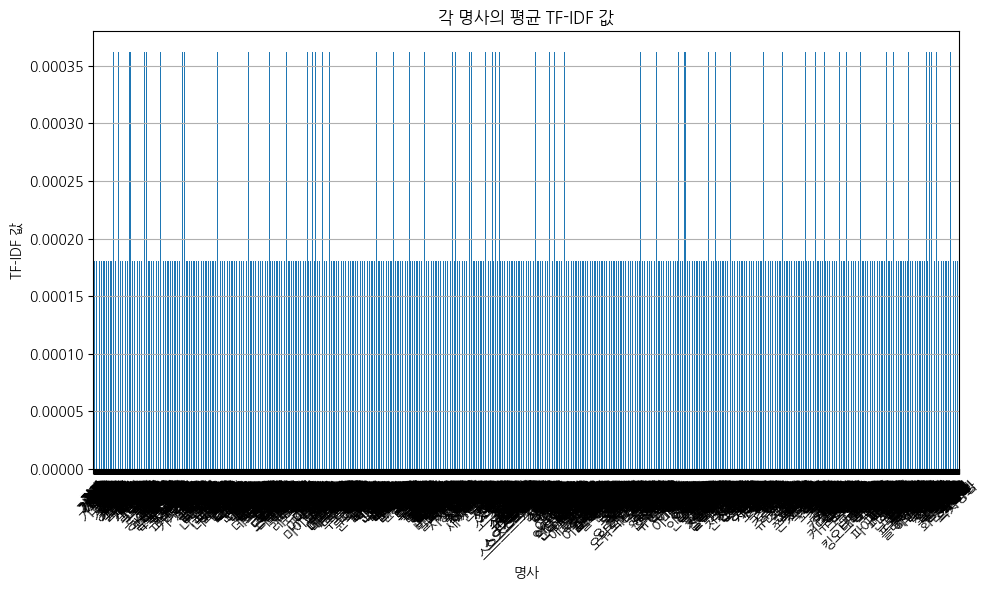

In [61]:
# TF-IDF 값들의 평균 계산
tfidf_mean = tfidf_df.mean()

# TF-IDF 값들을 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
tfidf_mean.plot(kind='bar')
plt.title('각 명사의 평균 TF-IDF 값')
plt.xlabel('명사')
plt.ylabel('TF-IDF 값')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 연결중심성 시각화

In [62]:
df_expanded['댓글']

0       배송은 생각보다 빨리도착했네요 손목 스트랩 쌍레드 디자인 이쁘고 마감처리 깔끔하고 ...
1            배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천ㅋ
2       정말 좋습니다 기대이상인듯 만원대 나 의 리프팅 스트랩에 비교해도 기능성으로는 전혀...
3       개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼방...
4                        아 배송은 일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다
                              ...                        
7445                                                  좋아요
7446    꼽았는데 반응이 전혀읍네뽑기실패꼽았는데 반응이 전혀읍네뽑기실패꼽았는데 반응이 전혀읍...
7447                                        감사합니다 잘 쓰겠습니다
7448                                          좋아요 잘 쓰겠습니다
7449                             작동잘되고 상태 멀쩡합니다 굿 잘쓰는중입니다
Name: 댓글, Length: 7450, dtype: object

In [63]:
noun_df_freq['명사']

0        배송
1        생각
2        도착
3        손목
4       스트랩
       ... 
5525     컬러
5526     배소
5527     하자
5528     처리
5529     자국
Name: 명사, Length: 5530, dtype: object

#### 네트워크 그래프 생성 및 연결 중심성 계산

In [64]:
okt = Okt()

# 명사 추출 함수
def extract_nouns(text):
    return okt.nouns(text)

# 데이터프레임에 명사 추출 적용
df_expanded['nouns'] = df_expanded['댓글'].apply(extract_nouns)


In [65]:
# 네트워크 그래프 생성 및 연결 중심성 계산
def calculate_centrality(df):
    G = nx.Graph()

    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(list(centrality.items()), columns=['명사', '연결 중심성'])
    return centrality_df, G

# 연결 중심성 계산
centrality_df, G = calculate_centrality(df_expanded)


In [66]:
# 명사 빈도 데이터프레임 생성
nouns_df = pd.merge(centrality_df, noun_df_freq[['명사', '빈도']], on='명사', how='left')

# NaN 값을 제거합니다.
nouns_df = nouns_df.dropna(subset=['빈도'])
nouns_df.sort_values(by='빈도', ascending=False)

,명사,연결 중심성,빈도
0,배송,0.444833,1388.0
85,가격,0.432861,1162.0
51,사용,0.415915,1047.0
216,제품,0.392890,1020.0
30,가성,0.289188,677.0
...,...,...,...
3484,빌드,0.003316,1.0
3485,평택,0.004605,1.0
3487,빛샘,0.004605,1.0
3492,슈로대,0.001842,1.0


In [67]:
# 네트워크 그래프 생성 함수
def create_network_graph(df):
    G = nx.Graph()

    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)

    return G

def visualize_network(G, title, font_family='NanumGothic', font_size=10):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_size=[G.degree(n) * 10 for n in G.nodes],
            node_color='skyblue', font_size=font_size, alpha=0.7)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    # 노드에 라벨 추가
    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family='NanumGothic', font_size=font_size)
    plt.title(title)
    plt.show()

In [68]:
# 긍정과 부정 리뷰 분리
positive_reviews = df_expanded[df_expanded['review_list'] == '긍정']
negative_reviews = df_expanded[df_expanded['review_list'] == '부정']

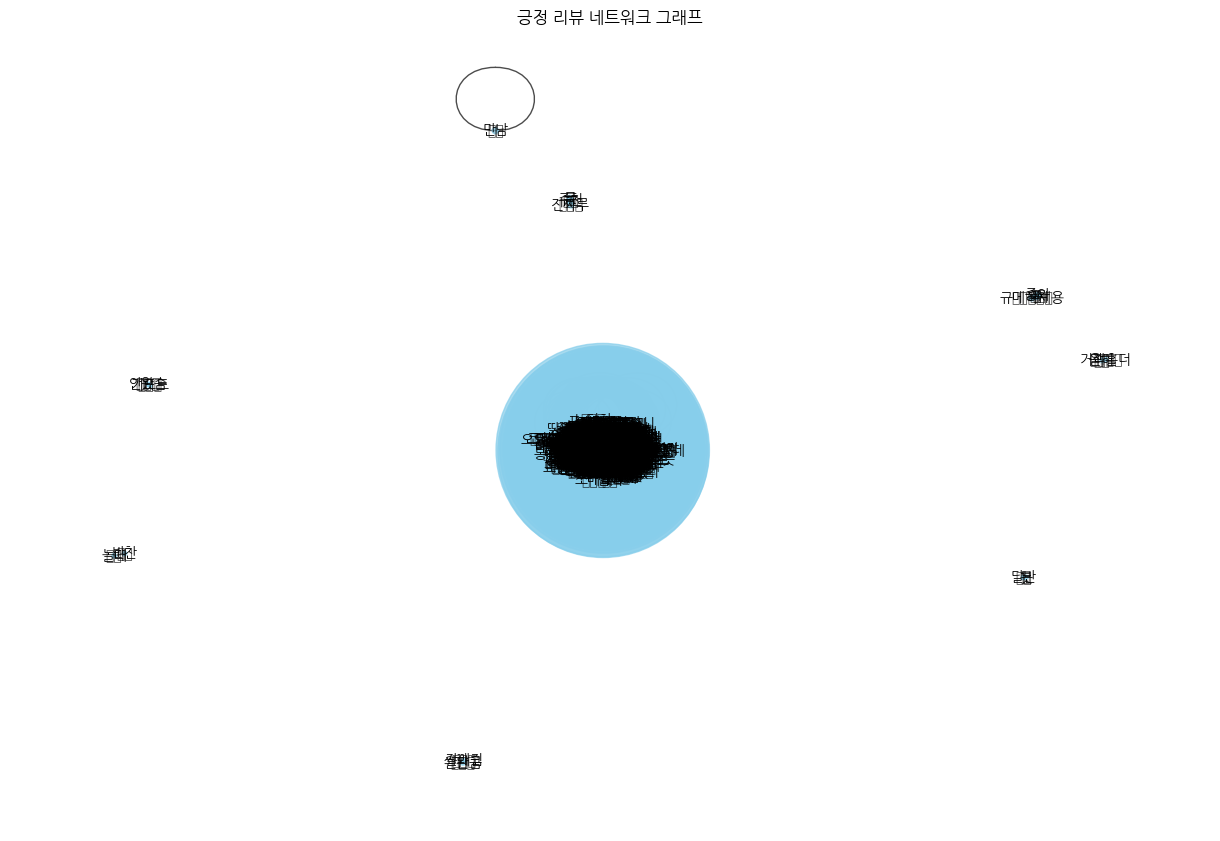

In [69]:
# 긍정 리뷰 네트워크 그래프 생성 및 시각화
positive_graph = create_network_graph(positive_reviews)
visualize_network(positive_graph, '긍정 리뷰 네트워크 그래프')



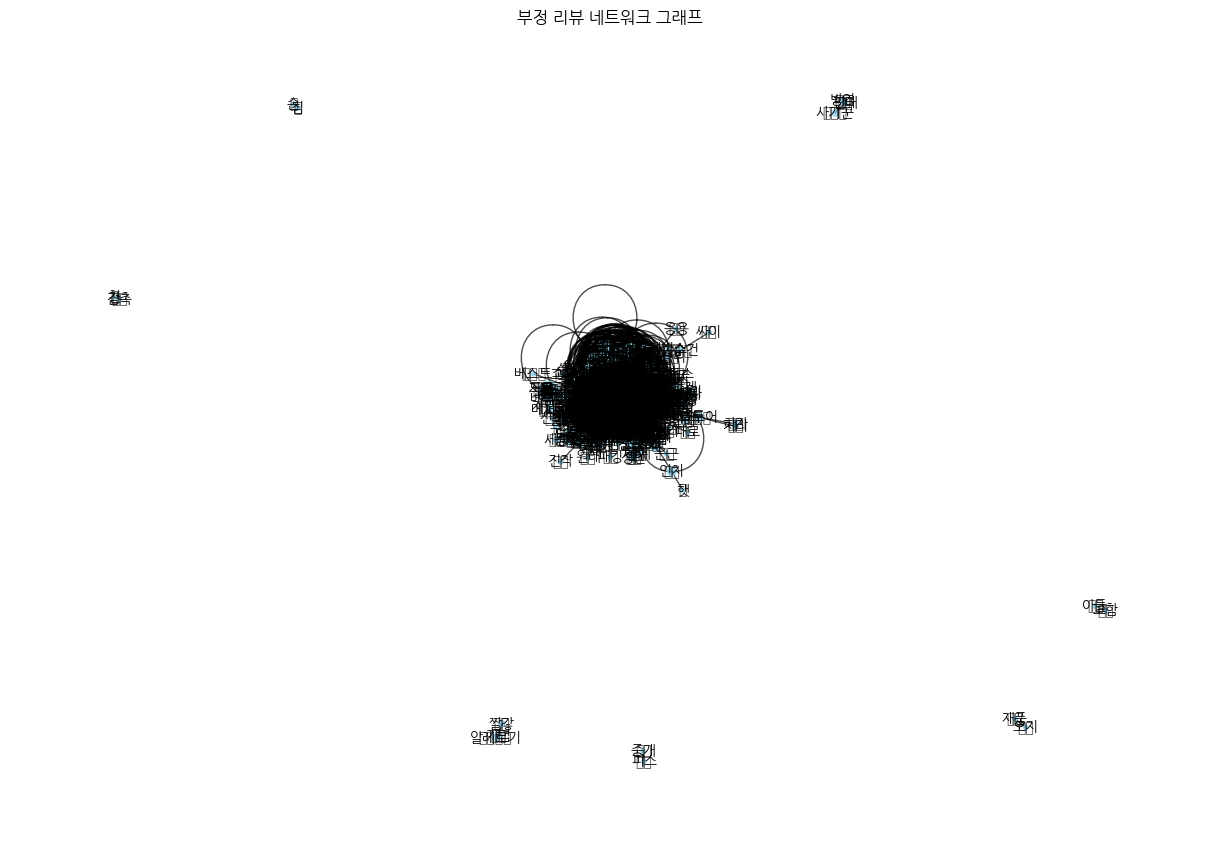

In [70]:
# 부정 리뷰 네트워크 그래프 생성 및 시각화
negative_graph = create_network_graph(negative_reviews)
visualize_network(negative_graph, '부정 리뷰 네트워크 그래프')

#### 긍정 부정 네트워크 군집분석

In [73]:
'''
!pip install python-louvain
'''

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     --------- --------------------------- 51.2/204.6 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=363b3adbb50e7c2729c888e2a83b980d1f7dd4f9bcda02b9916f441d8985a682
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\d0\b0\d7\6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain


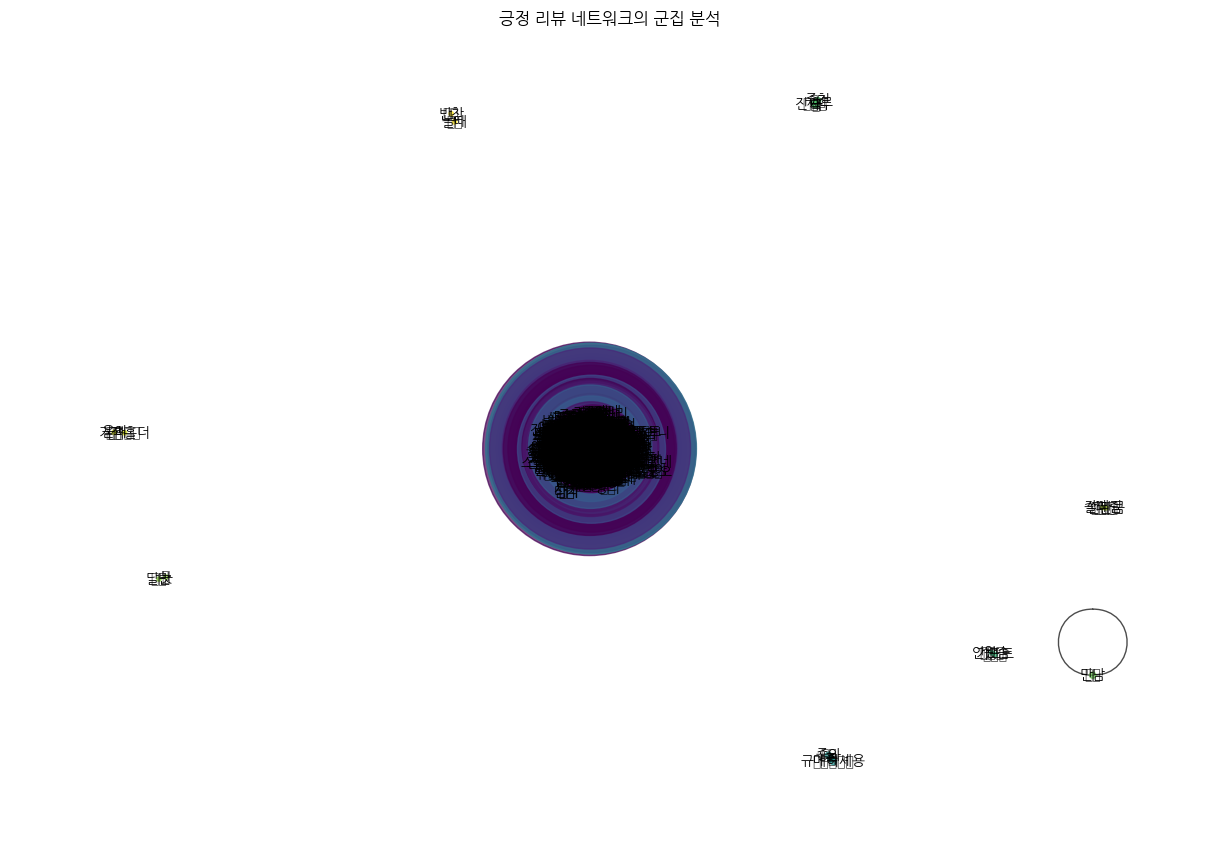

In [74]:
from community import community_louvain

def visualize_communities(G, partition, title, font_family='NanumGothic', font_size=10):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw(G, pos, node_color=[partition[node] for node in G.nodes()],
            node_size=[G.degree(n) * 10 for n in G.nodes],
            cmap=cmap, with_labels=True, font_size=font_size, alpha=0.7)

    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    plt.title(title)
    plt.show()


# 부정 리뷰 네트워크 그래프 생성
positive_graph = create_network_graph(positive_reviews)

# Louvain 알고리즘을 사용하여 군집 탐지
partition = community_louvain.best_partition(positive_graph)

# 군집 시각화
visualize_communities(positive_graph, partition, '긍정 리뷰 네트워크의 군집 분석')

In [75]:
# 네트워크 그래프 생성 함수
def create_network_graph(df):
    G = nx.Graph()
    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)
    return G

# 긍정 리뷰 네트워크 그래프 생성
positive_graph = create_network_graph(positive_reviews)

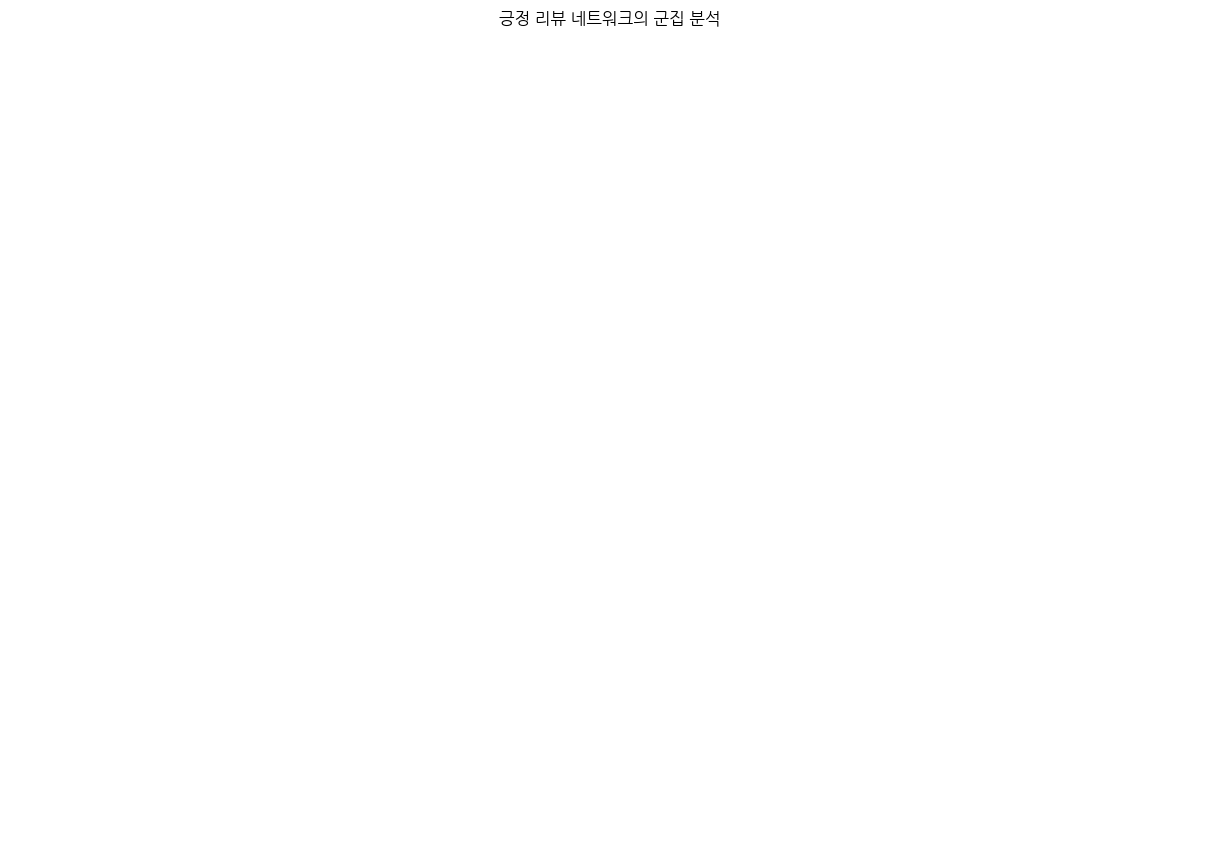

In [76]:
# 연결 중심성 계산
centrality = nx.edge_betweenness_centrality(positive_graph, weight='weight')

# 엣지 중심성이 높은 것만 필터링
threshold = 0.01  # 중심성의 임계값 설정
edges = [edge for edge in centrality.items() if edge[1] > threshold]

# 필터링된 엣지로 새로운 그래프 생성
H = nx.Graph()
for edge, weight in edges:
    u, v = edge
    H.add_edge(u, v, weight=weight)

# 군집 탐지 및 시각화
partition = community_louvain.best_partition(H)

def visualize_communities(G, partition, title, font_family='NanumGothic', font_size=30):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw(G, pos, node_color=[partition[node] for node in G.nodes()],
            node_size=[G.degree(n) * 10 for n in G.nodes],
            cmap=cmap, with_labels=True, font_size=font_size, alpha=0.7)

    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    plt.title(title)
    plt.show()

# 시각화
visualize_communities(H, partition, '긍정 리뷰 네트워크의 군집 분석')


#### 긍정 리뷰 키워드 빈도 분석

In [77]:
# 긍정 리뷰 텍스트 가져오기
positive_reviews_text = positive_reviews['댓글']

# CountVectorizer를 사용하여 키워드 빈도 분석
vectorizer = CountVectorizer(tokenizer=okt.nouns)
X = vectorizer.fit_transform(positive_reviews_text)
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)

# 키워드와 빈도를 DataFrame으로 정리
word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=['Keyword', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# 상위 50개의 키워드만 추출
top_50_keywords = word_freq.head(50)
print(top_50_keywords)


   Keyword  Frequency
0       배송       1388
1       가격       1162
2       사용       1047
3       제품       1020
4       가성        677
5        비        594
6       구매        550
7       생각        492
8       대비        453
9       아주        420
10      충전        368
11      작동        362
12       것        346
13       좀        321
14       굿        292
15      도착        292
16      추천        287
17       개        284
18      정도        282
19       때        265
20       더        265
21       이        244
22      매우        229
23      상품        223
24      구입        216
25      최고        214
26       거        209
27      품질        208
28      조금        202
29       용        196
30      성능        195
31      연결        190
32      주문        190
33       함        190
34       일        187
35      만족        177
36       키        173
37      정말        170
38       수        165
39      포장        163
40      그냥        156
41       듯        147
42      사진        141
43      게임        141
44      알리

In [78]:
# 상위 50개 키워드 표 생성
top_50_keywords['Rank'] = range(1, 51)
top_50_keywords = top_50_keywords[['Rank', 'Keyword', 'Frequency']]

print(top_50_keywords)


    Rank Keyword  Frequency
0      1      배송       1388
1      2      가격       1162
2      3      사용       1047
3      4      제품       1020
4      5      가성        677
5      6       비        594
6      7      구매        550
7      8      생각        492
8      9      대비        453
9     10      아주        420
10    11      충전        368
11    12      작동        362
12    13       것        346
13    14       좀        321
14    15       굿        292
15    16      도착        292
16    17      추천        287
17    18       개        284
18    19      정도        282
19    20       때        265
20    21       더        265
21    22       이        244
22    23      매우        229
23    24      상품        223
24    25      구입        216
25    26      최고        214
26    27       거        209
27    28      품질        208
28    29      조금        202
29    30       용        196
30    31      성능        195
31    32      연결        190
32    33      주문        190
33    34       함        190
34    35       일    

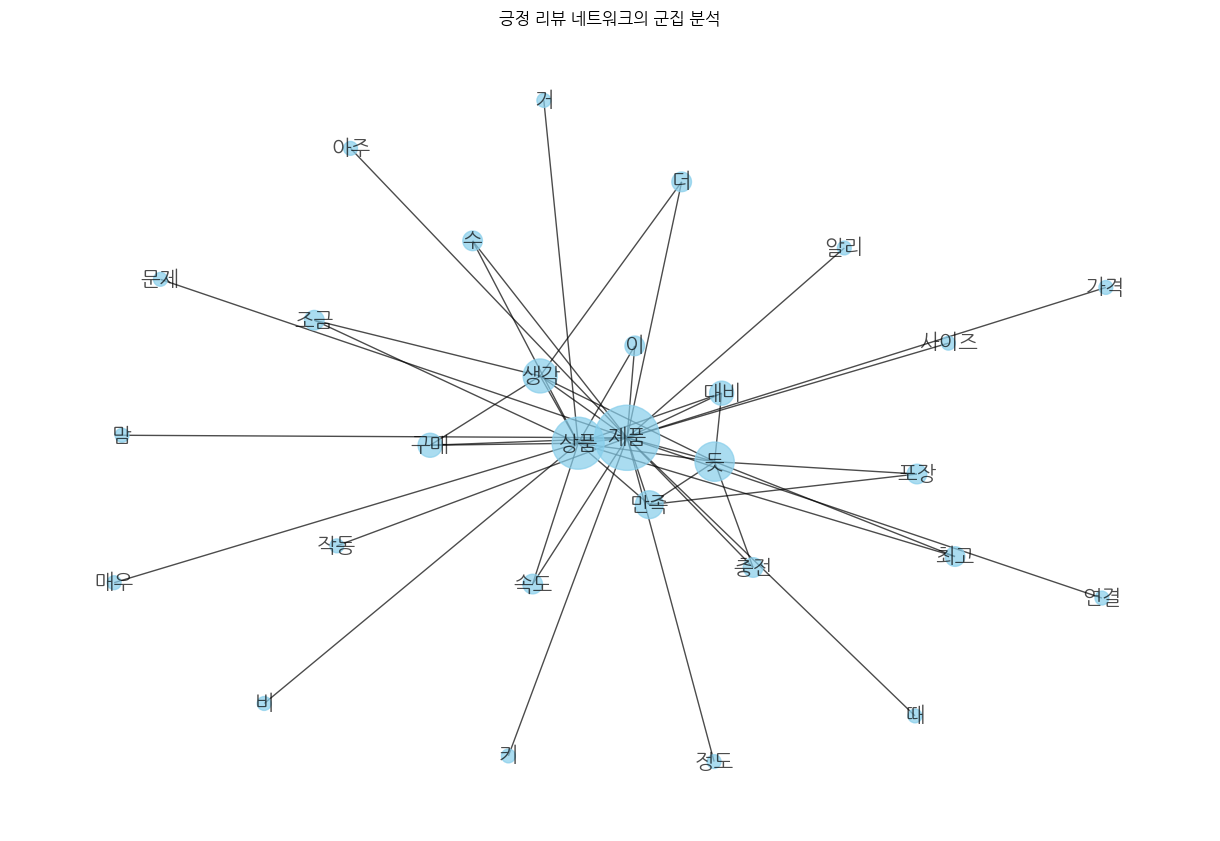

In [79]:
# 출현 빈도가 높은 50개의 핵심 키워드의 연결 및 연결 강도
top_keywords = top_50_keywords['Keyword'].tolist()

# 키워드 쌍 빈도 계산
co_occurrence = X.T * X
co_occurrence.setdiag(0)  # 자기 자신과의 연관성을 0으로 설정
co_occurrence = co_occurrence.toarray()

# 그래프 생성
G = nx.Graph()

for i in range(len(top_keywords)):
    for j in range(i + 1, len(top_keywords)):
        if co_occurrence[i, j] > 0:
            G.add_edge(top_keywords[i], top_keywords[j], weight=co_occurrence[i, j])

# 그래프 시각화
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.degree(n) * 100 for n in G.nodes],
        node_color='skyblue', font_size=15, alpha=0.7, font_family='NanumGothic')

plt.title('긍정 리뷰 네트워크의 군집 분석')
plt.show()

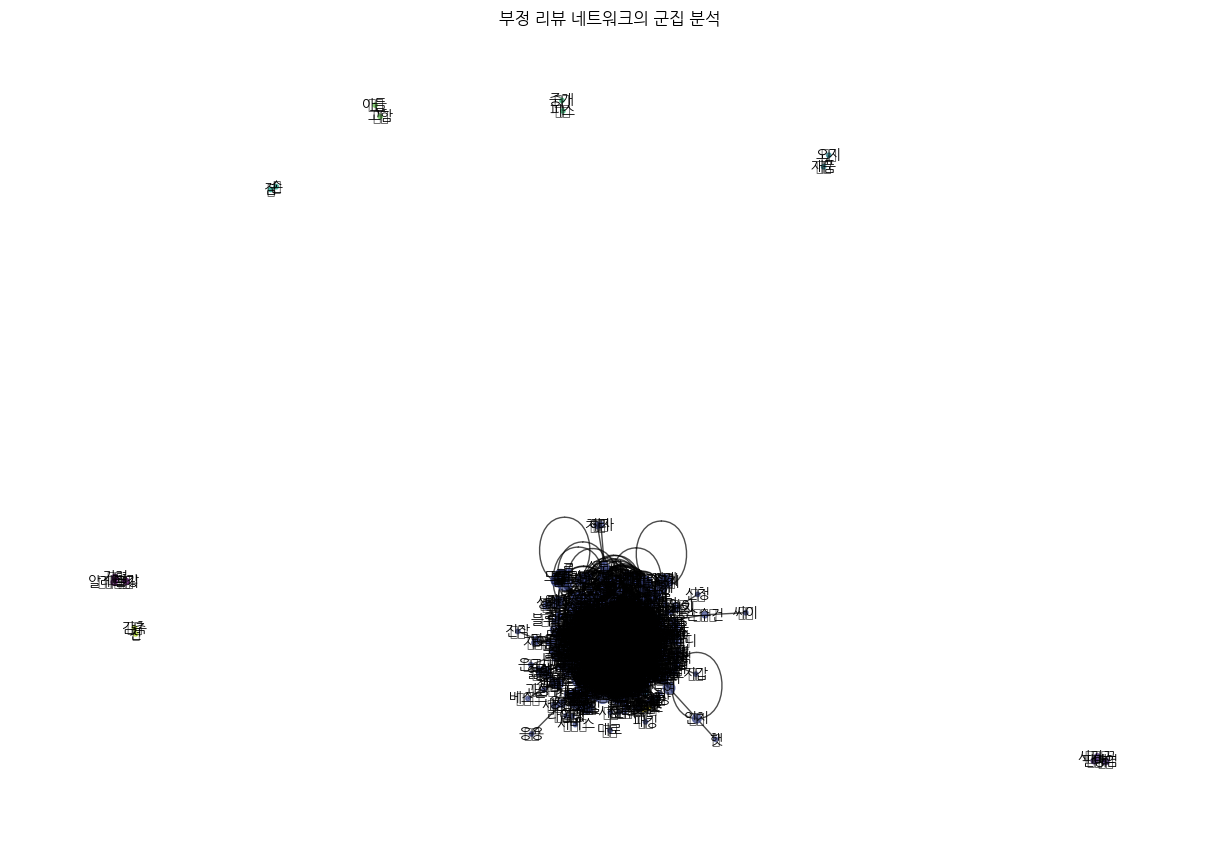

In [80]:
from community import community_louvain

def visualize_communities(G, partition, title, font_family='NanumGothic', font_size=10):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw(G, pos, node_color=[partition[node] for node in G.nodes()],
            node_size=[G.degree(n) * 10 for n in G.nodes],
            cmap=cmap, with_labels=True, font_size=font_size, alpha=0.7)

    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    plt.title(title)
    plt.show()


# 부정 리뷰 네트워크 그래프 생성
negative_graph = create_network_graph(negative_reviews)

# Louvain 알고리즘을 사용하여 군집 탐지
partition = community_louvain.best_partition(negative_graph)

# 군집 시각화
visualize_communities(negative_graph, partition, '부정 리뷰 네트워크의 군집 분석')


In [81]:
partition # Louvain 방법을 통해 얻은 partition 딕셔너리는 각 노드(단어)가 어떤 군집에 속하는지를 나타냅니다.

{'알레르기': 0,
 '가렵': 0,
 '짤갛': 0,
 '다음': 2,
 '날': 2,
 '먹음': 2,
 '미사': 2,
 '용': 2,
 '중립': 2,
 '평가': 2,
 '배송': 2,
 '매우': 2,
 '과성뷔': 2,
 '유': 2,
 '상품': 2,
 '때기': 2,
 '스타일': 2,
 '제품': 2,
 '상태': 2,
 '설명': 2,
 '그대로': 2,
 '환불': 2,
 '신청': 2,
 '가성': 2,
 '비': 2,
 '대비': 3,
 '고기': 2,
 '잡기': 2,
 '내': 2,
 '극치': 2,
 '짱개': 2,
 '사기': 2,
 '아이': 2,
 '장난감': 2,
 '가격': 3,
 '구멍': 2,
 '치기': 2,
 '가지': 2,
 '절대': 2,
 '자꾸': 2,
 '도': 2,
 '가끔': 2,
 '뻐': 2,
 '지구': 2,
 '고정': 2,
 '운동': 2,
 '치수': 2,
 '크게': 2,
 '주문': 2,
 '대박': 2,
 '원': 2,
 '품질': 2,
 '읍니': 2,
 '라이딩': 2,
 '개': 2,
 '음': 2,
 '센터': 2,
 '마무리': 2,
 '밴드': 2,
 '개인': 2,
 '구매': 2,
 '정도': 2,
 '좀': 2,
 '위': 2,
 '국산': 2,
 '고무': 2,
 '이': 2,
 '실리콘': 2,
 '함량': 2,
 '거': 2,
 '특유': 2,
 '쫀득하': 2,
 '탄성': 2,
 '감': 2,
 '일반': 2,
 '라텍스': 2,
 '조금': 2,
 '초기': 2,
 '일정': 2,
 '수치': 2,
 '힘': 2,
 '고무밴드': 2,
 '완만': 2,
 '분': 2,
 '패스': 2,
 '문제': 2,
 '박스': 2,
 '바퀴': 2,
 '남': 2,
 '보임': 2,
 '보이': 2,
 '다만': 2,
 '조립': 2,
 '아주': 2,
 '퀄리티': 2,
 '만족': 2,
 '막': 2,
 '생각': 2,
 '사용': 2,
 '그랜드': 2,
 '타'

In [82]:
# 네트워크 그래프 생성 함수
def create_network_graph(df):
    G = nx.Graph()
    for nouns in df['nouns']:
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)
    return G

# 부정 리뷰 네트워크 그래프 생성
negative_graph = create_network_graph(negative_reviews)


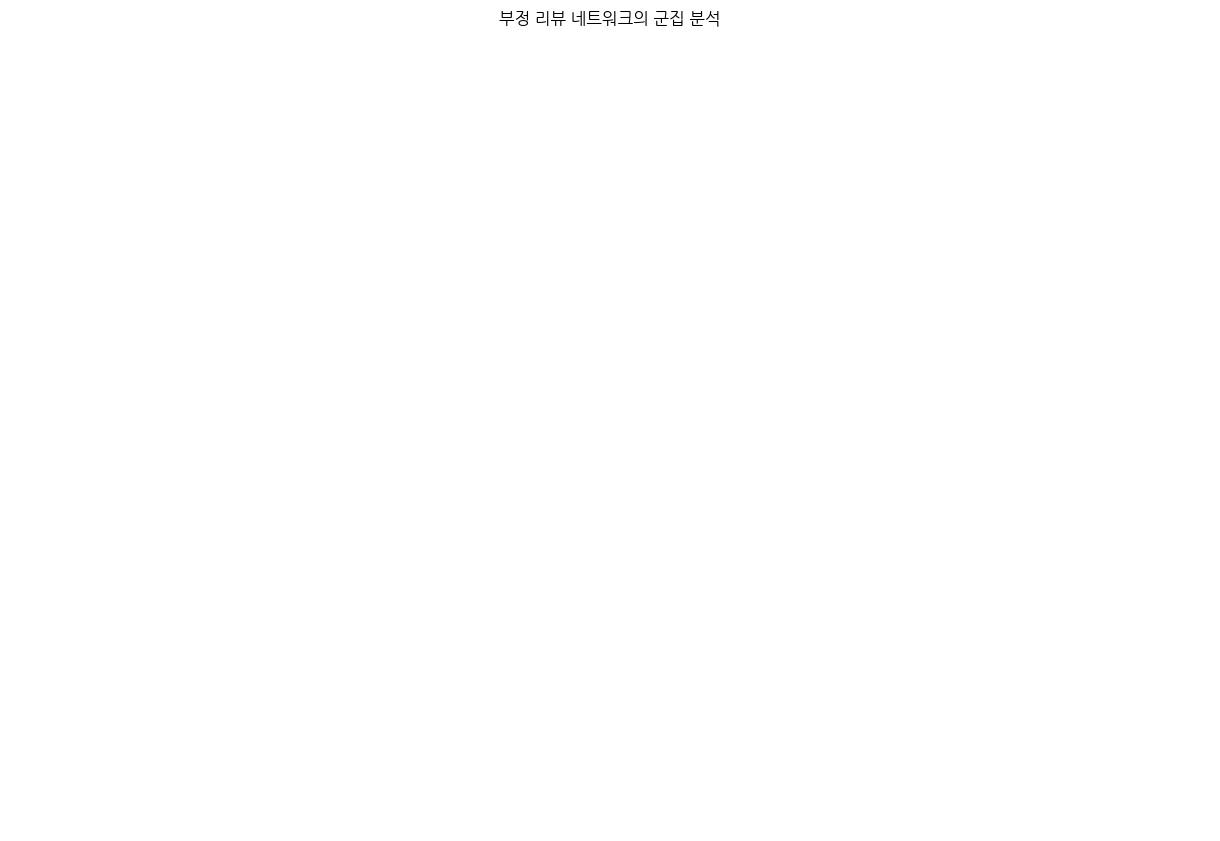

In [83]:
# 연결 중심성 계산
centrality = nx.edge_betweenness_centrality(negative_graph, weight='weight')

# 엣지 중심성이 높은 것만 필터링
threshold = 0.01  # 중심성의 임계값 설정
edges = [edge for edge in centrality.items() if edge[1] > threshold]

# 필터링된 엣지로 새로운 그래프 생성
H = nx.Graph()
for edge, weight in edges:
    u, v = edge
    H.add_edge(u, v, weight=weight)

# 군집 탐지 및 시각화
partition = community_louvain.best_partition(H)

def visualize_communities(G, partition, title, font_family='NanumGothic', font_size=30):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap('viridis')
    nx.draw(G, pos, node_color=[partition[node] for node in G.nodes()],
            node_size=[G.degree(n) * 10 for n in G.nodes],
            cmap=cmap, with_labels=True, font_size=font_size, alpha=0.7)

    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    plt.title(title)
    plt.show()

# 시각화
visualize_communities(H, partition, '부정 리뷰 네트워크의 군집 분석')


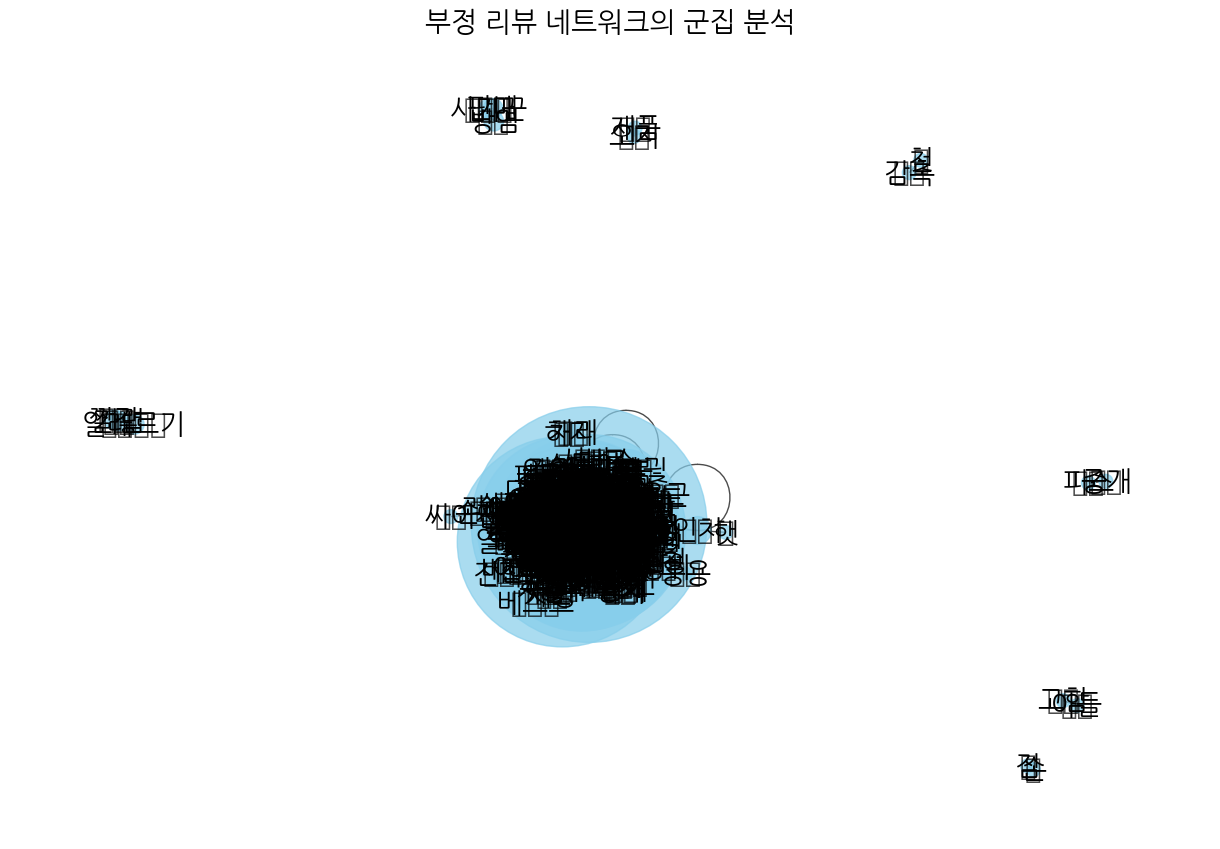

In [84]:
# 연결 중심성 계산
centrality = nx.edge_betweenness_centrality(negative_graph, weight='weight')

# 엣지 중심성이 높은 것만 필터링
threshold = 0.01  # 중심성의 임계값 설정
edges = [edge for edge in centrality.items() if edge[1] > threshold]

# 필터링된 엣지로 새로운 그래프 생성
H = nx.Graph()
for edge, weight in edges:
    u, v = edge
    H.add_edge(u, v, weight=weight)

# 군집 탐지 및 시각화
partition = community_louvain.best_partition(H)

def visualize_network(G, title, font_family='NanumGothic', font_size=20):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_size=[G.degree(n) * 100 for n in G.nodes],  # 노드 크기 키움
            node_color='skyblue', font_size=font_size, alpha=0.7)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    # 노드에 라벨 추가
    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)
    plt.title(title, fontsize=20)  # 제목 크기 키움
    plt.show()

# 부정 리뷰 네트워크 그래프 생성 및 시각화
negative_reviews = df_expanded[df_expanded['review_list'] == '부정']
negative_graph = create_network_graph(negative_reviews)
visualize_network(negative_graph, '부정 리뷰 네트워크의 군집 분석')

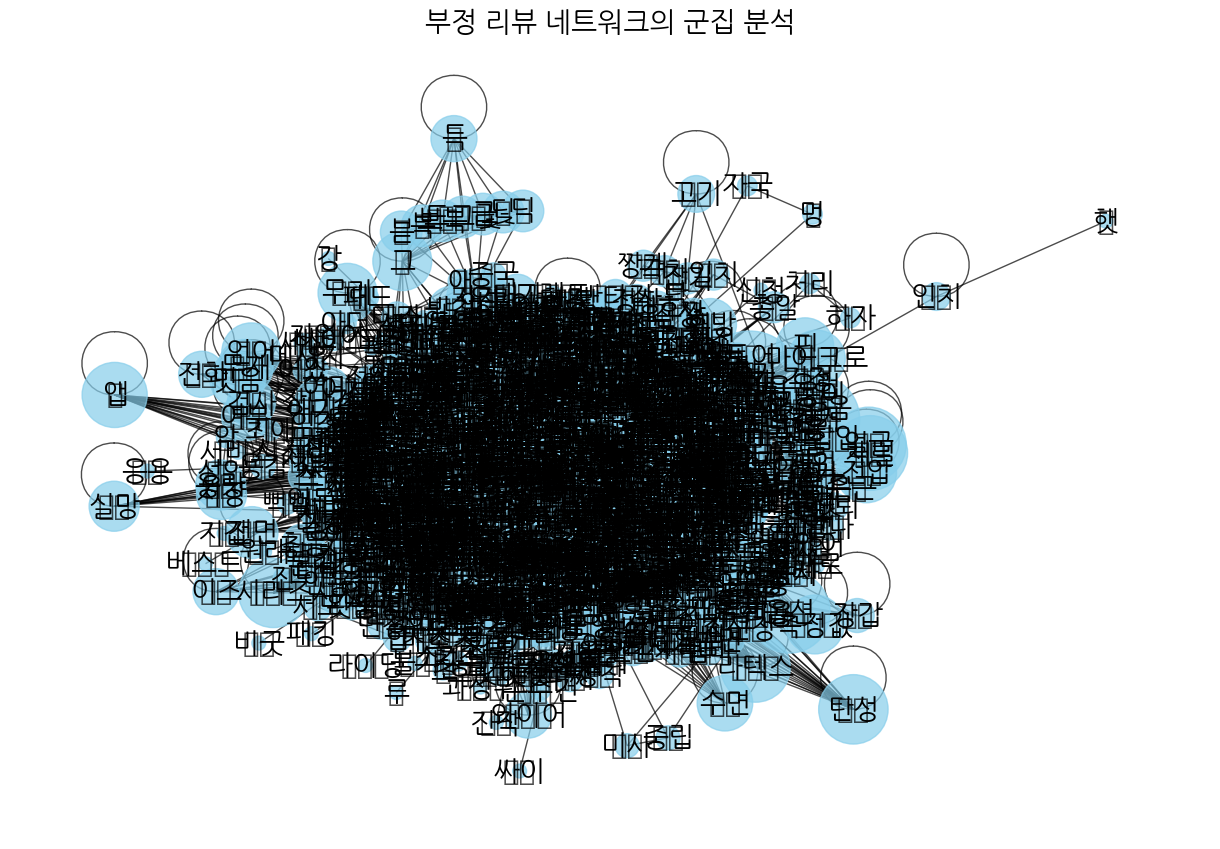

In [85]:
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# 연결 중심성 계산
centrality = nx.edge_betweenness_centrality(negative_graph, weight='weight')

# 엣지 중심성이 높은 것만 필터링
threshold = 0.01  # 중심성의 임계값 설정
edges = [edge for edge in centrality.items() if edge[1] > threshold]

# 필터링된 엣지로 새로운 그래프 생성
H = nx.Graph()
for edge, weight in edges:
    u, v = edge
    H.add_edge(u, v, weight=weight)

# 군집 탐지 및 시각화
partition = community_louvain.best_partition(H)

def visualize_network(G, title, font_family='NanumGothic', font_size=20):
    plt.figure(figsize=(12, 8))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_size=[G.degree(n) * 100 for n in G.nodes],  # 노드 크기 키움
            node_color='skyblue', font_size=font_size, alpha=0.7)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)

    # 노드에 라벨 추가
    labels = {n: n for n in G.nodes()}  # 노드 값 자체를 라벨로 설정
    nx.draw_networkx_labels(G, pos, labels, font_family=font_family, font_size=font_size)
    plt.title(title, fontsize=20)  # 제목 크기 키움
    plt.show()

# 부정 리뷰 네트워크 그래프 생성 및 시각화
negative_reviews = df_expanded[df_expanded['review_list'] == '부정']
negative_graph = create_network_graph(negative_reviews)
visualize_network(negative_graph, '부정 리뷰 네트워크의 군집 분석')


#### 부정 리뷰 키워드 빈도 분석

In [88]:
negative_reviews

,상품명,댓글,가격,별점,review_list,index,nouns
33,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",아주아주 좋아요,"1,391",3,부정,33,[]
37,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송도빠르고 저렴하고좋습니다 ㅎㅎ,"1,391",3,부정,37,[배송]
38,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",아주좋아요,"1,391",3,부정,38,[아주]
46,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...",빠른배송 감사합니다,"1,125",3,부정,46,[배송]
181,"스포츠 방수 운동 요법 테이프 스티커, 운동 붕대, 근육 회복 보호대, 스트랩 통증...",좋아요,"1,391",3,부정,181,[]
...,...,...,...,...,...,...,...
7405,아이폰 X XR XS 맥스 11 12 프로 맥스용 OLED 스크린 LCD 디스플레이...,만족함,"11,496",3,부정,7405,[]
7416,아이폰 X XR XS 맥스 11 12 프로 맥스용 OLED 스크린 LCD 디스플레이...,터치가 밀리는게 있는듯,"11,496",2,부정,7416,[터치]
7435,아이폰 X XR XS 맥스 11 12 프로 맥스용 OLED 스크린 LCD 디스플레이...,하자가 있었지만 스토어에서 잘 처리해줌,"11,496",2,부정,7435,"[하자, 스토어, 처리]"
7436,아이폰 X XR XS 맥스 11 12 프로 맥스용 OLED 스크린 LCD 디스플레이...,액정에 멍자국 있어요,"11,496",1,부정,7436,"[액정, 멍, 자국]"


In [89]:
# 부정 리뷰 텍스트 가져오기
negative_reviews_text = negative_reviews['댓글']

# CountVectorizer를 사용하여 키워드 빈도 분석
vectorizer = CountVectorizer(tokenizer=okt.nouns)
X = vectorizer.fit_transform(negative_reviews_text)
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)

# 키워드와 빈도를 DataFrame으로 정리
word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=['Keyword', 'Frequency'])
word_freq = word_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# 상위 50개의 키워드만 추출
top_50_keywords = word_freq.head(50)
print(top_50_keywords)


   Keyword  Frequency
0       가격        199
1       대비        160
2        굿        152
3       배송        102
4       사용         56
5       제품         53
6       가성         51
7        비         47
8       생각         39
9       만족         34
10      아주         32
11      충전         31
12      그냥         23
13       좀         23
14      도착         22
15       개         22
16      상품         21
17       것         20
18      성능         19
19      작동         18
20       일         17
21      구매         17
22      품질         16
23      인식         16
24       함         16
25       때         16
26      정도         15
27      포장         13
28      게임         13
29      매우         13
30       요         12
31      최고         12
32       용         12
33      음질         12
34     케이스         12
35       거         11
36       더         11
37      설명         10
38      별로         10
39       안         10
40       임          9
41      보임          9
42      조금          9
43      터치          8
44      연결

In [90]:
# 상위 50개 키워드 표 생성
top_50_keywords['Rank'] = range(1, 51)
top_50_keywords = top_50_keywords[['Rank', 'Keyword', 'Frequency']]

print(top_50_keywords)


    Rank Keyword  Frequency
0      1      가격        199
1      2      대비        160
2      3       굿        152
3      4      배송        102
4      5      사용         56
5      6      제품         53
6      7      가성         51
7      8       비         47
8      9      생각         39
9     10      만족         34
10    11      아주         32
11    12      충전         31
12    13      그냥         23
13    14       좀         23
14    15      도착         22
15    16       개         22
16    17      상품         21
17    18       것         20
18    19      성능         19
19    20      작동         18
20    21       일         17
21    22      구매         17
22    23      품질         16
23    24      인식         16
24    25       함         16
25    26       때         16
26    27      정도         15
27    28      포장         13
28    29      게임         13
29    30      매우         13
30    31       요         12
31    32      최고         12
32    33       용         12
33    34      음질         12
34    35     케이스    

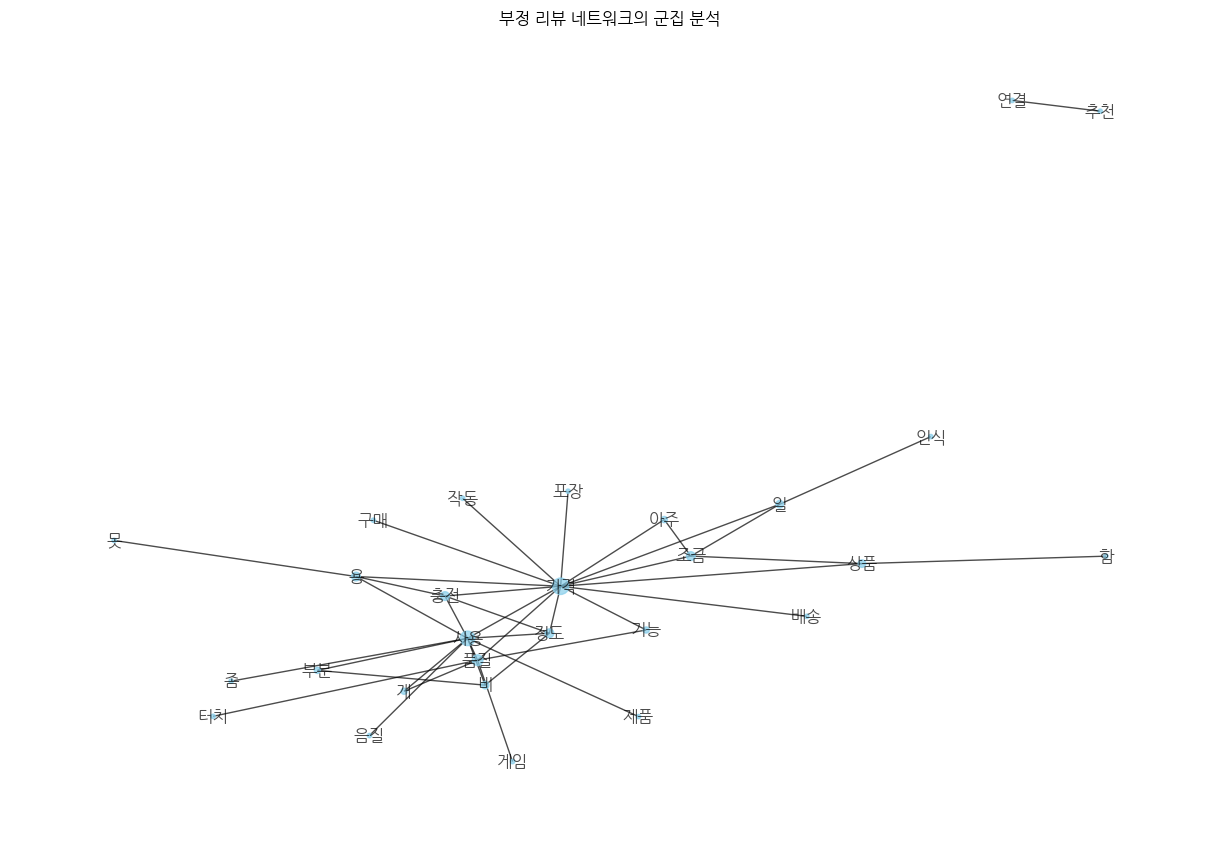

In [91]:
# 출현 빈도가 높은 50개의 핵심 키워드의 연결 및 연결 강도
top_keywords = top_50_keywords['Keyword'].tolist()

# 키워드 쌍 빈도 계산
co_occurrence = X.T * X
co_occurrence.setdiag(0)  # 자기 자신과의 연관성을 0으로 설정
co_occurrence = co_occurrence.toarray()

# 그래프 생성
G = nx.Graph()

for i in range(len(top_keywords)):
    for j in range(i + 1, len(top_keywords)):
        if co_occurrence[i, j] > 0:
            G.add_edge(top_keywords[i], top_keywords[j], weight=co_occurrence[i, j])

# 그래프 시각화
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.degree(n) * 10 for n in G.nodes],
        node_color='skyblue', font_size=12, alpha=0.7, font_family='NanumGothic')

plt.title('부정 리뷰 네트워크의 군집 분석')
plt.show()
